<a href="https://colab.research.google.com/github/cherylktt/tensorflow/blob/main/09_milestone_project_2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts earlier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

Reading through the paper above, we see that the model architecure that they usee to achieve their best results is available here: https://arxiv.org/abs/1612.05251

If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb).

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1409a56d-da47-9b06-ee91-cba097cdd89d)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used. We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


## Using 20K RCT dataset

In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [2]:
# Start our experiments using the 20k dataset with numbers replaced by the "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the files in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess data

Now that we've got some text data, it's time to become with it. One of the best ways to become one with the data is to visualise it. So with that in mind, let's write a function to read in all of the lines of a target text file.

In [3]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename (str): contains the target filepath
  
  Returns:
    A list of strings with one string per line form the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [4]:
# Let's read the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Let's think about how we want our data to look.

How our data would be best represented:

```
[{'line_numer': 0,
   'target_label': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
 ...
]
```


Let's write a function which turns each of our datasets into the above format.

In [5]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target lable, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
      
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()  # get text and lower it
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line_data to abstract_samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [34]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 436 ms, sys: 102 ms, total: 538 ms
Wall time: 592 ms


In [13]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualise it?

In [35]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [15]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

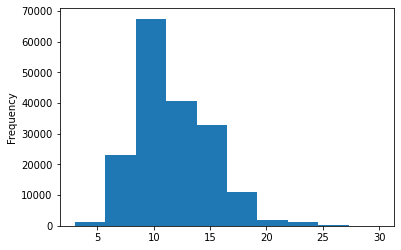

In [16]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

#### Get lists of sentences

In [36]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the first 14 lines of training sentences
train_sentences[:14]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [9]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # sparse matrix is incomptible with tensors
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), (180040, 5))

#### Label encode labels

In [10]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what the labels look like
train_labels_encoded, train_labels_encoded.shape

(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

In [11]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Modelling Experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

* `model_0`: Naive Bayes with TF-IDF encoder (baseline)
* `model_1`: Conv1D with token embeddings
* `model_2`: TensorFlow Hub Pretrained Feature Extractor
* `model_3`: Conv1D with character embeddings
* `model_4`: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
* `model_5`: Pretrained token embeddings + character embeddings + positional embeddings

And as always, we're going to start with a baseline.

### Model 0: Getting a baseline

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [13]:
# Evaluate our baseline
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy score of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy score of: 72.18%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
val_labels_encoded[:20]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1, 0, 0, 0, 3, 2, 2, 4, 4, 4, 4])

#### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from the helper function script.

In [19]:
!wget https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py

--2022-05-17 08:30:14--  https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16898 (17K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  16.50K  --.-KB/s    in 0.001s  

2022-05-17 08:30:14 (23.7 MB/s) - ‘helper_functions.py’ saved [16898/16898]



In [18]:
from helper_functions import calculate_results

In [ ]:
# Calculate basline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
# Save the model
from joblib import dump
dump(model_0, "/content/drive/MyDrive/tensorflow/skimlit/model_0.joblib")

['/content/drive/MyDrive/tensorflow/skimlit/model_0.joblib']

### Preparing our data for deep sequence models

Before we start building deep models, we've got to create vectorization and embedding layers.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
# Find the average number of tokens in the training sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

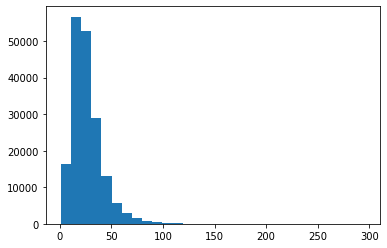

In [16]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

In [17]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [18]:
# Maximum sequence length in the training set
max(sent_lens)

296

#### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [19]:
from tensorflow.keras.layers import TextVectorization

# Set up text vectorization variables
max_tokens = 68000 # based on table 2 in https://arxiv.org/abs/1710.06071

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len,
                                    name="vectorizer")

In [20]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [21]:
# Test out text vectorizer on some random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Sentence:\n{target_sentence}\n")
print(f"Length of sentence: {len(target_sentence.split())}\n")
print(f"Vectorized sentence:\n{text_vectorizer([target_sentence])}\n")

Sentence:
among patients undergoing coronary stent placement with bms and who tolerated @ months of thienopyridine , continuing thienopyridine for an additional @ months compared with placebo did not result in statistically significant differences in rates of stent thrombosis , macce , or moderate or severe bleeding .

Length of sentence: 47

Vectorized sentence:
[[ 116   12  295  346  788 1164    7 3182    3   67  580   41    4 8792
  2899 8792   11   26  365   41   34    7   48  112   31  692    5  232
    37  102    5  162    4  788 1682 7051   16  362   16  289  506    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]



In [22]:
# How many words are there in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [28]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'vectorizer',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#### Create custom text embedding

In [23]:
embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero = True, # use masking to handle variable sequence lengths (save space)
                             name="token_embedding",
                             input_length=output_seq_len)

In [30]:
# View embedding on random sentences
print(f"Sentence:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Vectorized sentence before embedding:\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Embedded sentence:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence:
the hypotheses of this research are that individually tailored worksite-based intelligent physical exercise training , ipet , among workers with inactive job categories will : @ ) improve cardiorespiratory fitness and/or individual health risk indicators , @ ) improve muscle strength and decrease musculoskeletal disorders , @ ) succeed in regular adherence to worksite and leisure physical activity training , and @ ) reduce sickness absence and productivity losses ( presenteeism ) in office workers .

Vectorized sentence before embedding:
[[    2  4825     4    23   285    58    28  2846  1399 41795 18570   189
    177   155 54582   116  1693     7  3506  4425  3143    95   218  3860
   1586   727   565    97    73  2196   218   368   541     3   318  2797
    751 15388     5  1004   429     6 13562     3  6085   189   190   155
      3   270  4811  1461     3  3845  4483]]

Embedded sentence:
[[[ 0.00324992 -0.03465866  0.00100082 ... -0.04545168 -0.04238952
    0.01765925]
 

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow `tf.data API`. Many of the steps here are discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [24]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [25]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D model with token embeddings

In [26]:
from tensorflow.keras import layers
model_1_vectorizer = TextVectorization(max_tokens=max_tokens,
                                       output_sequence_length=output_seq_len,
                                       name="vectorizer_1")
model_1_vectorizer.adapt(train_sentences)
model_1_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                     output_dim=128,
                                     mask_zero = True,
                                     input_length=output_seq_len,
                                     name="embedding_1")

# Build a Conv1D model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectorizer = model_1_vectorizer(inputs)
embedding_layer = model_1_embedding(text_vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(embedding_layer)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D_with_token_embeddings")

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a model summary
model_1.summary()

Model: "model_1_Conv1D_with_token_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 vectorizer_1 (TextVectoriza  (None, 55)               0         
 tion)                                                           
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_5 (Dense)             (

In [27]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 9ms/step - loss: 0.9051 - accuracy: 0.6439 - val_loss: 0.6828 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6581 - accuracy: 0.7529 - val_loss: 0.6310 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6184 - accuracy: 0.7731 - val_loss: 0.5978 - val_accuracy: 0.7879


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5975 - accuracy: 0.7856


[0.5974841117858887, 0.7856149673461914]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.32427794e-01, 1.38925239e-01, 7.36574754e-02, 3.31097484e-01,
         2.38920283e-02],
        [4.24246401e-01, 2.71191835e-01, 1.29315546e-02, 2.81418949e-01,
         1.02111930e-02],
        [1.51432380e-01, 8.79561901e-03, 1.08053919e-03, 8.38662624e-01,
         2.88423362e-05],
        ...,
        [7.09087499e-06, 6.47899869e-04, 7.08986481e-04, 7.29126532e-06,
         9.98628736e-01],
        [5.89619316e-02, 3.90249789e-01, 1.20869644e-01, 8.16758201e-02,
         3.48242790e-01],
        [1.53286308e-01, 7.33524203e-01, 4.05976586e-02, 3.15901786e-02,
         4.10016365e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.56149874222163,
 'f1': 0.7830750189313805,
 'precision': 0.7827856109218004,
 'recall': 0.7856149874222164}

In [ ]:
# Save the model
model_1.save("/content/drive/MyDrive/tensorflow/skimlit/model_1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_1/assets


### Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the [universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/4).

The paper originally used GloVe embeddings, however we're going to stick with the later created USE pretrained embeddings.

In [28]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Embedded sentence:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
a growing number of studies have focused on the rtw processes associated with patients with back pain .

Embedded sentence:
[ 0.04138879  0.07120415  0.01941869 -0.02689958 -0.07418185  0.01032031
 -0.00074394 -0.01132685 -0.00621332  0.00731301  0.0836827   0.03256061
  0.06309229 -0.05973922  0.0225996   0.03757901 -0.09706851  0.02600738
 -0.06079616 -0.0249203  -0.06869026  0.07510655  0.00712351 -0.05196979
  0.04613668  0.07059016  0.00348197 -0.0761986   0.00759916 -0.08021192]

Length of sentence embedding: 512


#### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [29]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [30]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9137 - accuracy: 0.6507 - val_loss: 0.7986 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7689 - accuracy: 0.7002 - val_loss: 0.7556 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7527 - accuracy: 0.7119 - val_loss: 0.7384 - val_accuracy: 0.7131


In [ ]:
# Evalute the model
model_2.evaluate(val_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7375 - accuracy: 0.7159


[0.7374598383903503, 0.7158744931221008]

In [ ]:
# Make predictions and calculate results
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.58744869588243,
 'f1': 0.7127957127036705,
 'precision': 0.7164332869986845,
 'recall': 0.7158744869588243}

In [ ]:
# Save the model
model_2.save("/content/drive/MyDrive/tensorflow/skimlit/model_2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_2/assets


> `model_2` performed way worse than `model_1` and around the same as `model_0` (baseline model)

### Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously, we've used token-level embeddings, but we'll need to do similar steps for characters if we want to use char-level embeddings.

#### Creating a character-level tokenizer

In [35]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [32]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character level sequence into characters
import random
random_train_sentence = random.choice(train_sentences)
split_chars(random_train_sentence)

"q u a l i t a t i v e   e x a m i n a t i o n   o f   p a r t i c i p a n t s   '   s c o r e s   s u g g e s t e d   i n c r e a s e d   m i n d f u l n e s s   b u t   i n c o n s i s t e n t   p a t t e r n s   o n   o t h e r   o u t c o m e   m e a s u r e s   ."

In [37]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [33]:
# What's the average character length?
import numpy as np
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

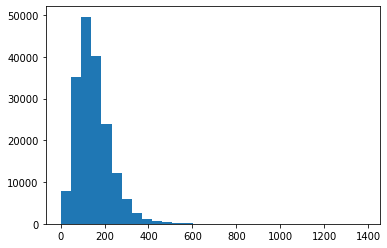

In [39]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_len, bins=30);

In [34]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [35]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [36]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and 00V token (out of vocab '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    #standardize=None, # for if you want to leave punctuation in
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [37]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [38]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [45]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}\n")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
n o   m a r k e d   a d v e r s e   e v e n t s   w e r e   o b s e r v e d   a f t e r   u s i n g   n a s a l   g l p - @   .

Length of random_train_chars: 54

Vectorized chars:
[[ 6  7 15  5  8 23  2 10  5 10 21  2  8  9  2  2 21  2  6  3  9 20  2  8
   2  7 22  9  2  8 21  2 10  5 17  3  2  8 16  9  4  6 18  6  5  9  5 12
  18 12 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

#### Creating a character-level embedding layer

In [39]:
# Create character embedding layer
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=25, # this is the size of char embedding in the paper
                                  mask_zero=True,
                                  name="char_embedding")

In [47]:
# Test our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
print(f"Vectorized chars:\n{vectorized_chars}\n")
embedded_chars = char_embedding(vectorized_chars)
print(f"Embedded chars:\n{embedded_chars}\n")
print(f"Shape of embedded chars: {embedded_chars.shape}")

Charified text:
n o   m a r k e d   a d v e r s e   e v e n t s   w e r e   o b s e r v e d   a f t e r   u s i n g   n a s a l   g l p - @   .

Length of random_train_chars: 54

Vectorized chars:
[[ 6  7 15  5  8 23  2 10  5 10 21  2  8  9  2  2 21  2  6  3  9 20  2  8
   2  7 22  9  2  8 21  2 10  5 17  3  2  8 16  9  4  6 18  6  5  9  5 12
  18 12 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

#### Creating char level datasets

In [40]:
# Turn our data into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Building a Conv1D model to fit on charcater embeddings

In [41]:
# Build the model
model_3_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_3")
model_3_char_vectorizer.adapt(train_chars)
model_3_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25, # this is the size of char embedding in the paper
                                          mask_zero=True,
                                          name="embedding_3")

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorizer = model_3_char_vectorizer(inputs)
char_embeddings = model_3_char_embedding(char_vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_with_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_3.summary()

Model: "model_3_Conv1D_with_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer_3 (TextVect  (None, 290)              0         
 orization)                                                      
                                                                 
 embedding_3 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (N

In [42]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2449 - accuracy: 0.5041 - val_loss: 1.0342 - val_accuracy: 0.5911
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9961 - accuracy: 0.6041 - val_loss: 0.9273 - val_accuracy: 0.6356
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9159 - accuracy: 0.6450 - val_loss: 0.8619 - val_accuracy: 0.6695


In [ ]:
# Evaluate the model
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8813 - accuracy: 0.6582


[0.8813233375549316, 0.6581822037696838]

In [ ]:
# Make predictions and calculate results
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.81821792665166,
 'f1': 0.6485758353174247,
 'precision': 0.654761303831174,
 'recall': 0.6581821792665166}

In [ ]:
# Save the model
model_3.save("/content/drive/MyDrive/tensorflow/skimlit/model_3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_3/assets


> `model_3` underperforms the baseline `model_0` quite significantly

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine the outputs of 1 & 2 using `tf.keras.layer.Concatenate`
4. Build a series of output layers on top of step 3 (similar to Figure 1 and section 4.2 of https://arxiv.org/abs/1612.05251)
5. Construct a model with takes token and charcater-level sequence as input and produces sequence label probabilities as output

#### Building a hybrid model

In [43]:
model_4_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_4")
model_4_char_vectorizer.adapt(train_chars)
model_4_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="embedding_4")

In [44]:
# 1. Setup token inputs / model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs / model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = model_4_char_vectorizer(char_inputs)
char_embeddings = model_4_char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-LSTM shown in Figure 1 of the paper
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat) # dropout helps prevent overfitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer_4 (TextVectori  (None, 290)         0           ['char_input[0][0]']             
 zation)                                                                                          
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

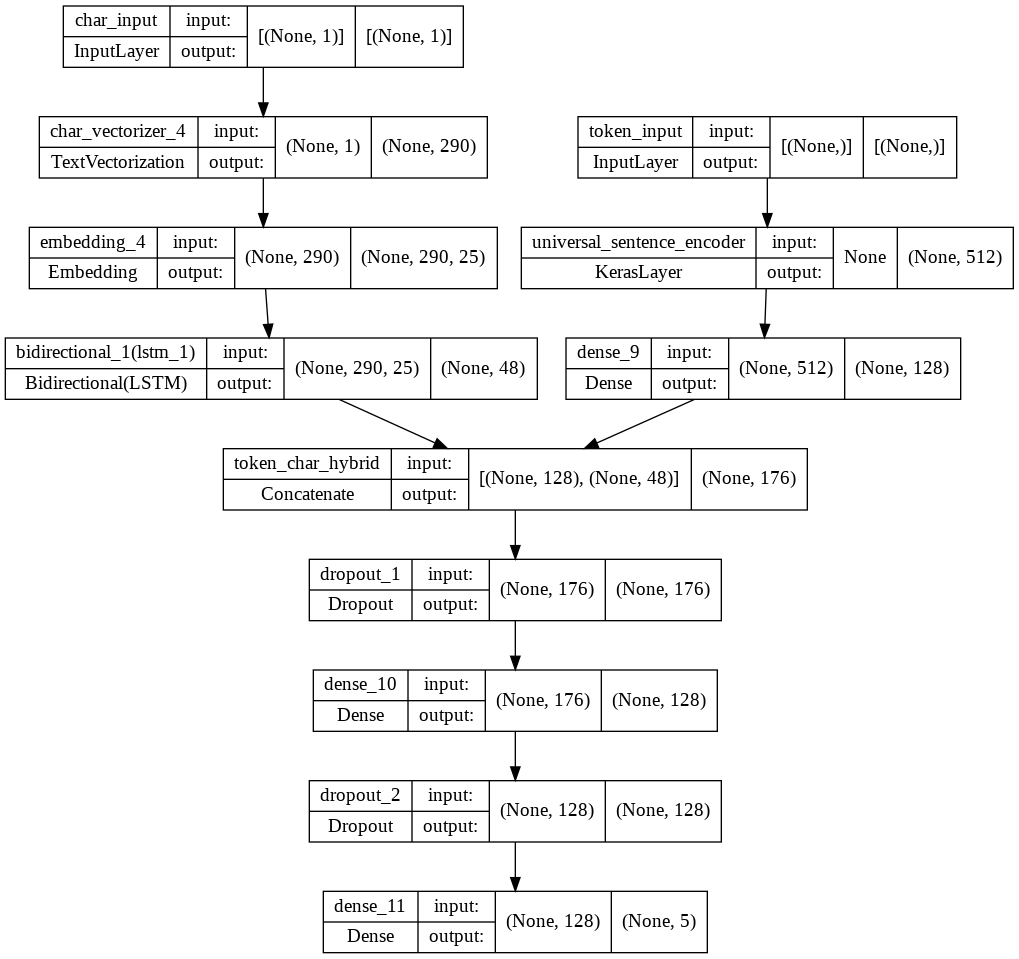

In [ ]:
# Plot hybrid token and character model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [45]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Combining token and character data into a tf.data Dataset

In [46]:
# Combine token and chars into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
# Repeat the above steps for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
# Check out training and validation token and char embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting a model and token and character=level sequences

In [48]:
model_4_history = model_4.fit(train_token_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 55ms/step - loss: 0.9930 - accuracy: 0.6074 - val_loss: 0.7849 - val_accuracy: 0.7038
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8041 - accuracy: 0.6900 - val_loss: 0.7263 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.7788 - accuracy: 0.7025 - val_loss: 0.7023 - val_accuracy: 0.7377


In [ ]:
# Evaluate the model
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 48s 51ms/step - loss: 0.7014 - accuracy: 0.7346


[0.7013501524925232, 0.7346087694168091]

In [ ]:
# Make predictions and calculate results
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.46087647292467,
 'f1': 0.732155895096914,
 'precision': 0.733879546026775,
 'recall': 0.7346087647292466}

In [ ]:
# Save the model
model_4.save("/content/drive/MyDrive/tensorflow/skimlit/model_4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_4/assets


### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [52]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

#### Creating positional embeddings

In [53]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

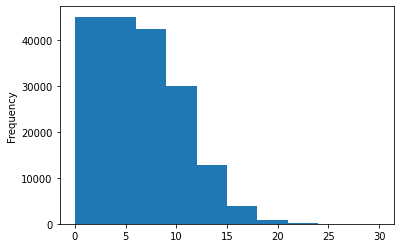

In [54]:
# Check the distribution of line_number column
train_df.line_number.plot.hist();

In [49]:
# Use TensorFlow to create one-hot encoded tensors of the line_number column
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:14], train_line_number_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [56]:
# How many total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

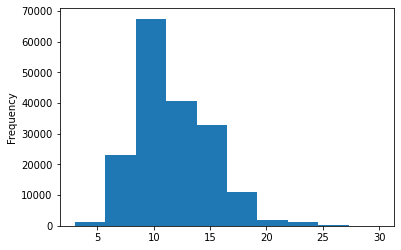

In [57]:
# Check the distribution
train_df.total_lines.plot.hist();

In [58]:
# Check the coverage of a total_lines values of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [50]:
# Use TensorFlow to create one-hot-encoded tensors of the total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a charcater-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model` 

In [51]:
model_5_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_5")
model_5_char_vectorizer.adapt(train_chars)
model_5_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="char_embedding_5")

In [52]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = model_5_char_vectorizer(char_inputs)
char_embeddings = model_5_char_embedding(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [53]:
# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [54]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="positional_token_char_tribrid_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input], # the order is important
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of the model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer_5 (TextVectori  (None, 290)         0           ['char_inputs[0][0]']            
 zation)                                                                                          
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

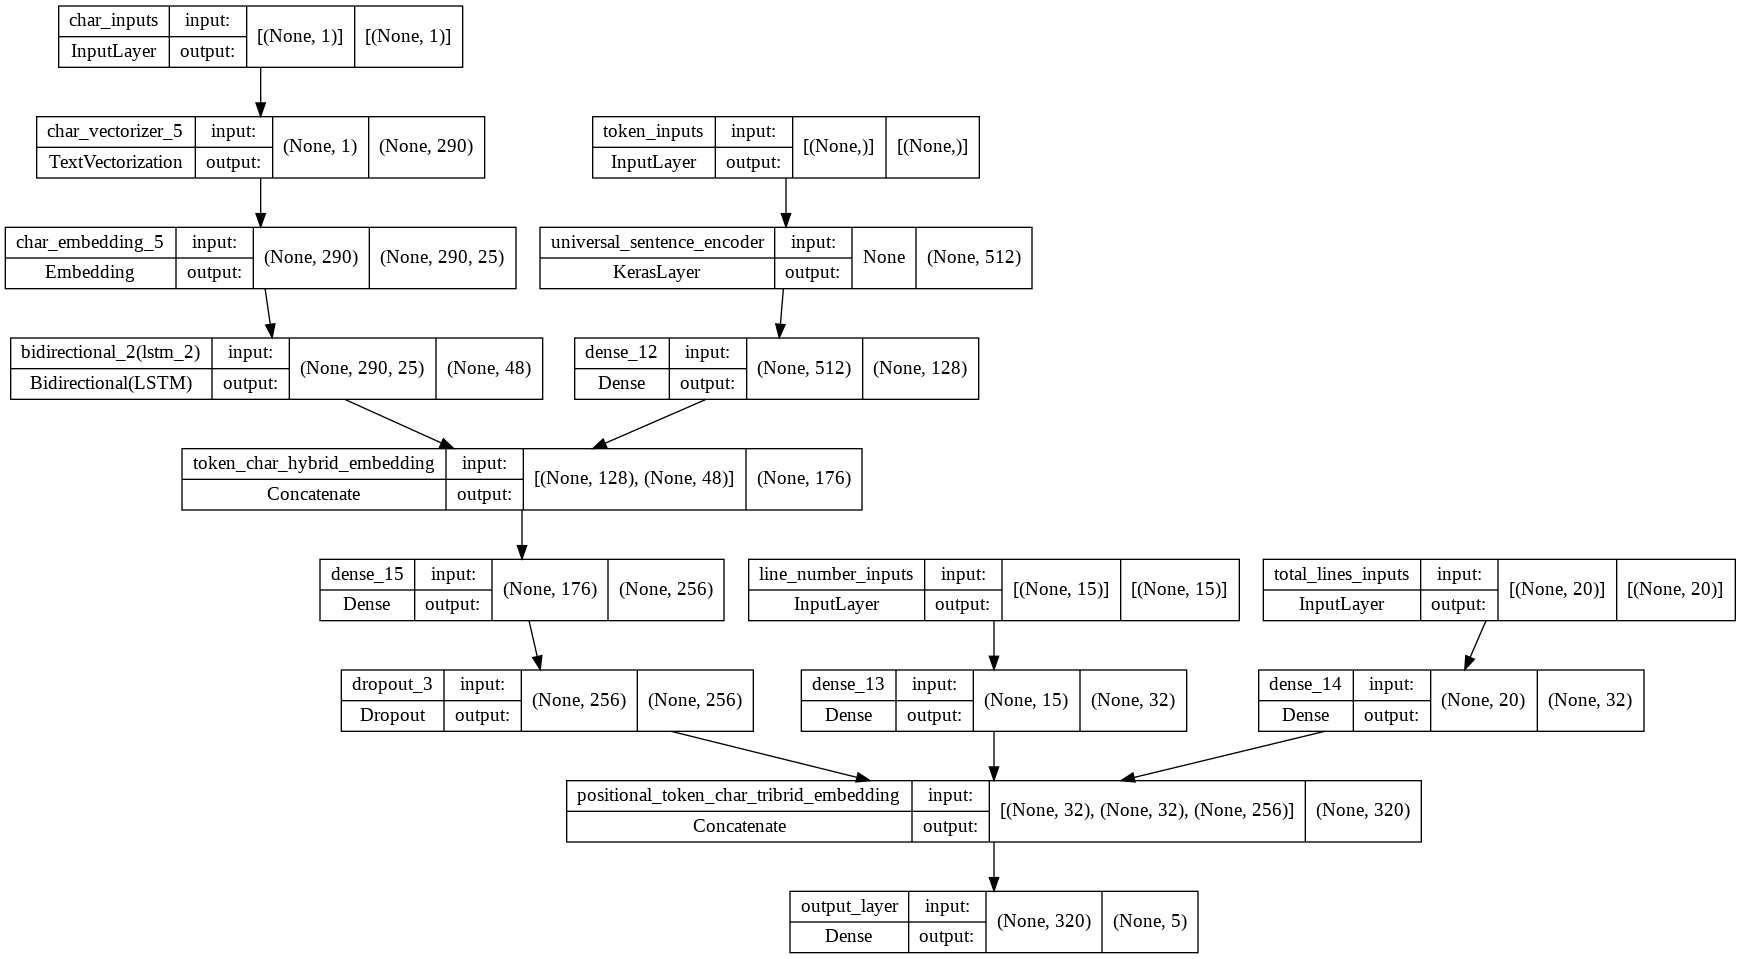

In [ ]:
# Plot tribrid model_5 to explore it visually
tf.keras.utils.plot_model(model_5, show_shapes=True)

**What is label smoothing?**

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class not consider other classes (tunnel vision).

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred probs to other classes, in turn, hopefully improving generalisation: `[0.01, 0.01, 0.96, 0.01, 0.01]`

For more on label smoothing, see this blog post from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [55]:
# Compile positional, token, char embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Creating tribid embedding datasets using tf.data

In [56]:
# Create training and validation datasets with all 4 kinds of input data
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                         train_total_lines_one_hot,
                                                         train_sentences,
                                                         train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                       val_total_lines_one_hot,
                                                       val_sentences,
                                                       val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting, evaluate and making predictions with our tribrid model

In [57]:
# Fit the model
model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 54ms/step - loss: 1.1000 - accuracy: 0.7205 - val_loss: 0.9850 - val_accuracy: 0.7972
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9670 - accuracy: 0.8146 - val_loss: 0.9501 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9497 - accuracy: 0.8239 - val_loss: 0.9384 - val_accuracy: 0.8295


In [ ]:
# Evaluate the model
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.9395 - accuracy: 0.8312


[0.9395098686218262, 0.8311929106712341]

In [ ]:
# Make predictions and calculate results
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.11929034820601,
 'f1': 0.8303255051877018,
 'precision': 0.8302847831281369,
 'recall': 0.8311929034820601}

In [ ]:
# Save the model
model_5.save("/content/drive/MyDrive/tensorflow/skimlit/model_5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_5/assets


### Model 6: Custom token embeddings + character embeddings + positional embeddings

#### Building a tribrid custom embedding model

In [58]:
# Create text vectorization and embedding layers for tokens
model_6_token_vectorizer = TextVectorization(max_tokens=max_tokens,
                                             output_sequence_length=output_seq_len,
                                             name="token_vectorizer_6")
model_6_token_vectorizer.adapt(train_sentences)
model_6_token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                           output_dim=128,
                                           mask_zero=True,
                                           input_length=output_seq_len,
                                           name="token_embedding_6")

In [59]:
# Create text vectorization and embedding layers for characters
model_6_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorization_6")
model_6_char_vectorizer.adapt(train_chars)
model_6_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="char_embedding_6")

In [60]:
# Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_inputs")
token_vectorizer = model_6_token_vectorizer(token_inputs)
token_embeddings = model_6_token_embedding(token_vectorizer)
token_flatten = layers.Flatten()(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(token_flatten)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = model_6_char_vectorizer(char_inputs)
char_embeddings = model_6_char_embedding(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [61]:
# Combine the models
custom_combined_embeddings = layers.Concatenate(name="custom_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(custom_combined_embeddings)
z = layers.Dropout(0.5)(z)

custom_tribrid_embeddings = layers.Concatenate(name="custom_tribrid_embedding")([line_number_model.output, total_lines_model.output, z])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(custom_tribrid_embeddings)
model_6 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_6_custom_tribrid_embedding_model")

In [ ]:
# Get a summary of the model
model_6.summary()

Model: "model_6_custom_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 token_vectorizer_6 (TextVector  (None, 55)          0           ['token_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_embedding_6 (Embedding)  (None, 55, 128)      8299648 

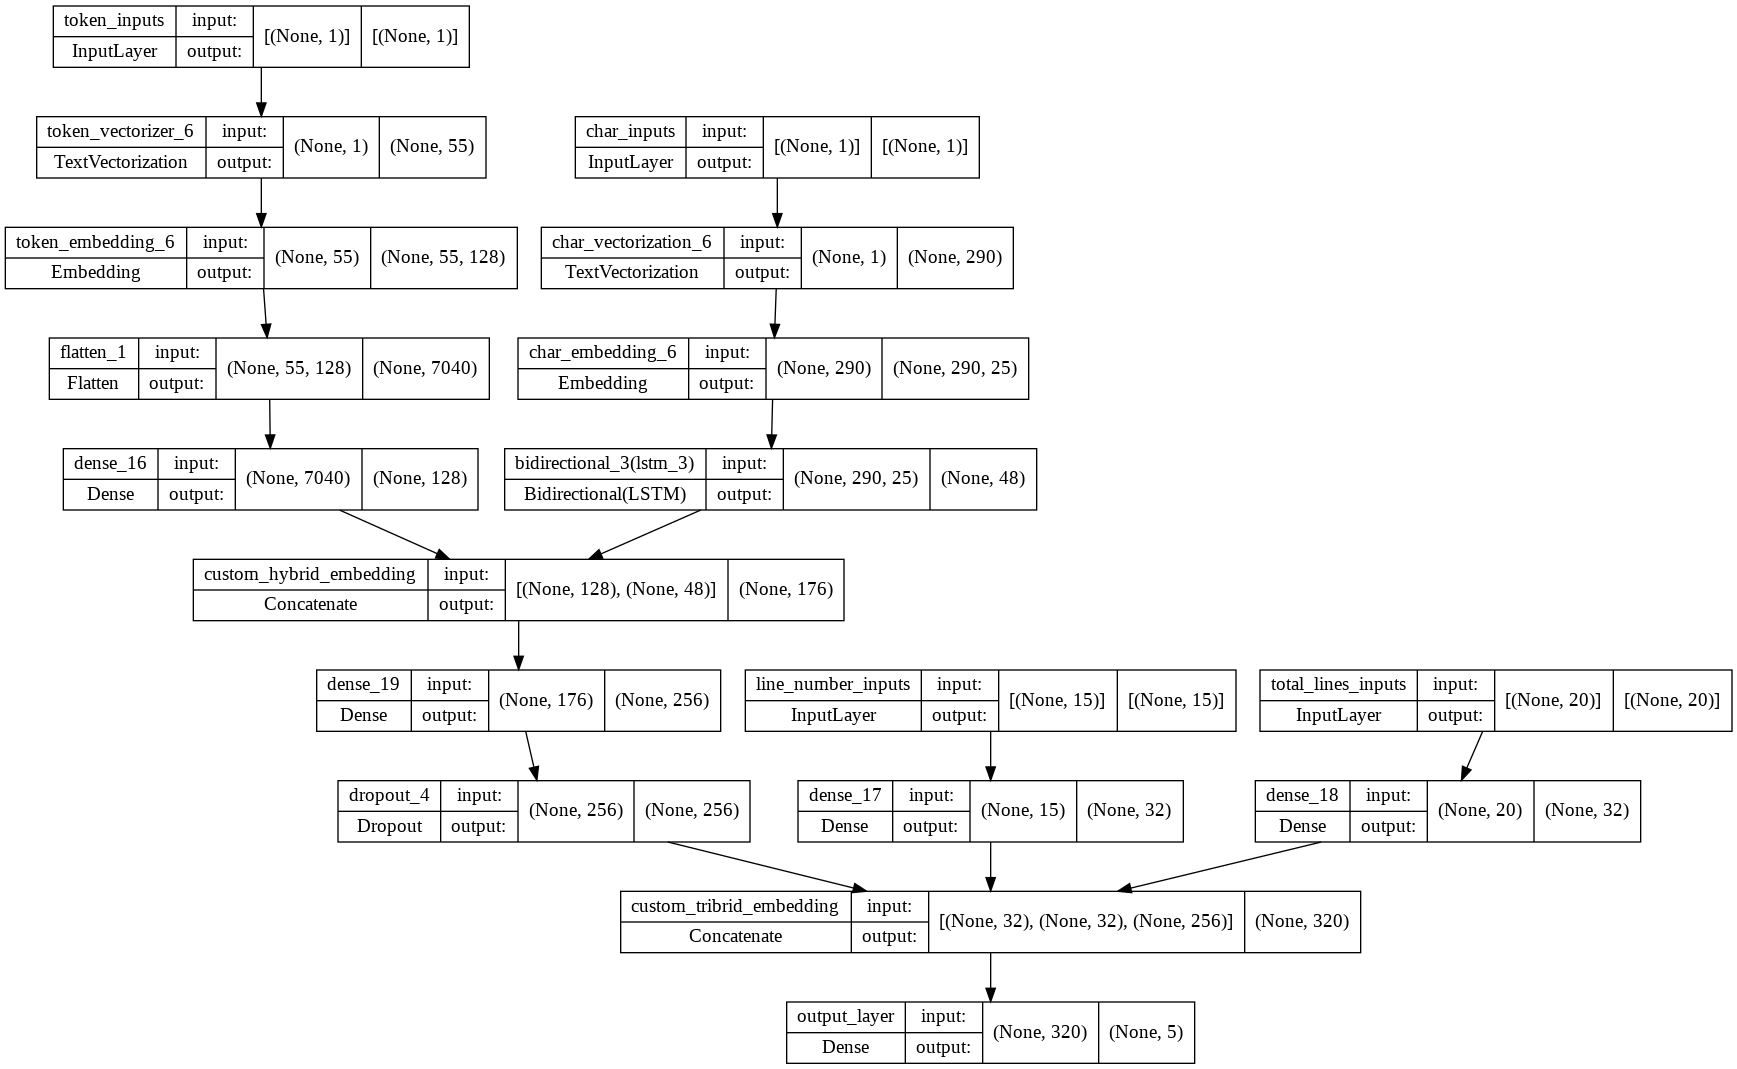

In [ ]:
# Plot model_6
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [62]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Fit the model
model_6_history = model_6.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 48ms/step - loss: 1.0969 - accuracy: 0.7255 - val_loss: 0.9316 - val_accuracy: 0.8371
Epoch 2/3
562/562 [==============================] - 24s 44ms/step - loss: 0.9359 - accuracy: 0.8369 - val_loss: 0.9132 - val_accuracy: 0.8441
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9163 - accuracy: 0.8475 - val_loss: 0.9034 - val_accuracy: 0.8501


In [ ]:
# Evaluate the model
model_6.evaluate(val_tribrid_dataset)

945/945 [==============================] - 40s 42ms/step - loss: 0.8992 - accuracy: 0.8559


[0.8992472290992737, 0.8559181690216064]

In [ ]:
# Make predictions
model_6_pred_probs = model_6.predict(val_tribrid_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

In [ ]:
# Calculate results
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 85.59181782073348,
 'f1': 0.8549365888670022,
 'precision': 0.8542556956036133,
 'recall': 0.8559181782073348}

In [ ]:
# Save the model
model_6.save("/content/drive/MyDrive/tensorflow/skimlit/model_6")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_6/assets


### Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_token_char_embedding": model_4_results,
                                  "model_5_tribrid_pos_token_char_embedding": model_5_results,
                                  "model_6_custom_tribrid_pos_token_char_embedding": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.561499,0.782786,0.785615,0.783075
model_2_pretrained_token_embedding,71.587449,0.716433,0.715874,0.712796
model_3_char_embedding,65.818218,0.654761,0.658182,0.648576
model_4_hybrid_token_char_embedding,73.460876,0.733880,0.734609,0.732156
model_5_tribrid_pos_token_char_embedding,83.119290,0.830285,0.831193,0.830326
model_6_custom_tribrid_pos_token_char_embedding,85.591818,0.854256,0.855918,0.854937


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

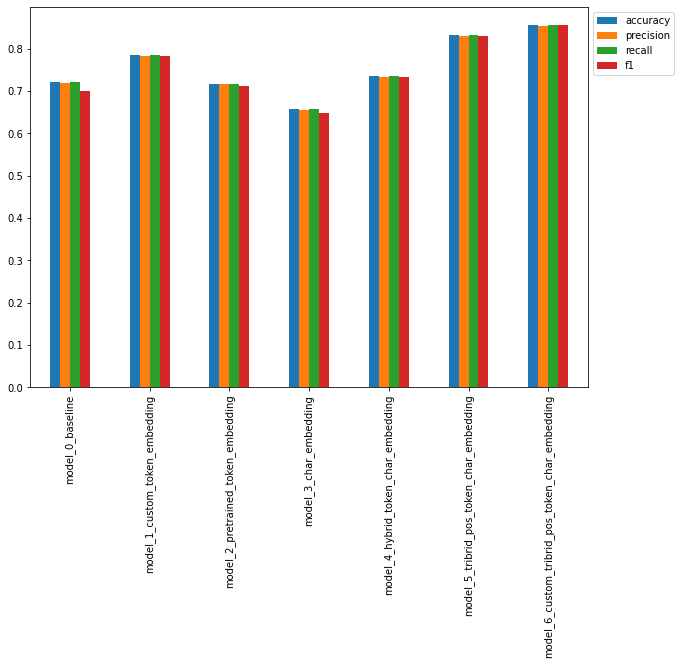

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

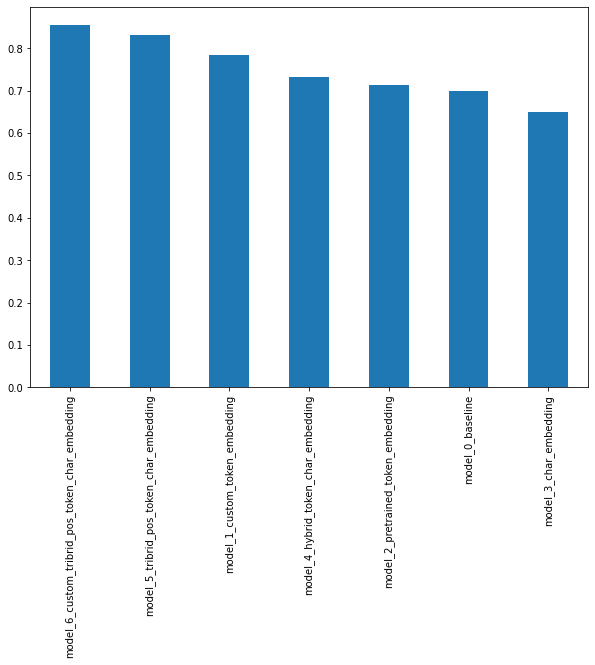

In [ ]:
# Sort models results by f1-scores
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_6.save("/content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model/assets


In [ ]:
# Load in the best performing model
loaded_model_6 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model")

In [ ]:
# Make predictions on the loaded model
loaded_model_6_pred_probs = loaded_model_6.predict(val_tribrid_dataset)
loaded_model_6_preds = tf.argmax(loaded_model_6_pred_probs, axis=1)

In [ ]:
# Calculate results of the loaded model
loaded_model_6_results = calculate_results(val_labels_encoded, loaded_model_6_preds)
loaded_model_6_results 

{'accuracy': 85.59181782073348,
 'f1': 0.8549365888670022,
 'precision': 0.8542556956036133,
 'recall': 0.8559181782073348}

In [ ]:
# Check if loaded model results is the same as the original model
model_6_results == loaded_model_6_results

True

### Creating test data samples making predictions on them using `model_6`

In [41]:
# Create testing datasets with all 4 kinds of input data
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                         test_total_lines_one_hot,
                                                         test_sentences,
                                                         test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Evaluate on the test dataset
model_6.evaluate(test_tribrid_dataset)

942/942 [==============================] - 40s 42ms/step - loss: 0.9070 - accuracy: 0.8521


[0.9069927334785461, 0.8520988821983337]

In [ ]:
# Make predictions on the test dataset
model_6_test_pred_probs = model_6.predict(test_tribrid_dataset)
model_6_test_preds = tf.argmax(model_6_test_pred_probs, axis=1)

In [ ]:
# Calculate results of predictions
model_6_test_results = calculate_results(test_labels_encoded, model_6_test_preds)
model_6_test_results

{'accuracy': 85.20988883358221,
 'f1': 0.8510824992042388,
 'precision': 0.8504132207603194,
 'recall': 0.8520988883358221}

### Finding the most wrong predictions

In [ ]:
predictions = pd.DataFrame({"line_number": test_df["line_number"],
                               "text": test_sentences,
                               "target": test_df["target"],
                               "pred": [class_names[i] for i in model_6_test_preds],
                               "pred_probs": model_6_test_pred_probs.max(axis=1)})
predictions[:20]

,line_number,text,target,pred,pred_probs
0,0,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE,0.513415
1,1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.659083
2,2,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,0.782813
3,3,survival analyses were used to assess the asso...,RESULTS,METHODS,0.675029
4,4,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,0.745160
5,5,when mean hemodynamic profiles were compared i...,RESULTS,RESULTS,0.915664
6,6,multivariable analyses revealed that patients ...,RESULTS,RESULTS,0.908762
7,7,abnormal lfts are common in the adhf populatio...,CONCLUSIONS,CONCLUSIONS,0.745347
8,8,elevated meld-xi scores are associated with po...,CONCLUSIONS,CONCLUSIONS,0.770931
9,0,minimally invasive endovascular aneurysm repai...,BACKGROUND,BACKGROUND,0.509542


In [ ]:
# Find the predictions that are most wrong
predictions["pred_correct"] = predictions["target"] == predictions["pred"]
predictions[:20]

,line_number,text,target,pred,pred_probs,pred_correct
0,0,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE,0.513415,False
1,1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.659083,False
2,2,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,0.782813,False
3,3,survival analyses were used to assess the asso...,RESULTS,METHODS,0.675029,False
4,4,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,0.745160,True
5,5,when mean hemodynamic profiles were compared i...,RESULTS,RESULTS,0.915664,True
6,6,multivariable analyses revealed that patients ...,RESULTS,RESULTS,0.908762,True
7,7,abnormal lfts are common in the adhf populatio...,CONCLUSIONS,CONCLUSIONS,0.745347,True
8,8,elevated meld-xi scores are associated with po...,CONCLUSIONS,CONCLUSIONS,0.770931,True
9,0,minimally invasive endovascular aneurysm repai...,BACKGROUND,BACKGROUND,0.509542,True


In [ ]:
# Sort the DataFrame to have the most wrong predictions on top
top_100_wrong = predictions[predictions["pred_correct"] == False].sort_values("pred_probs", ascending=False)[:100]
top_100_wrong.head(20)

,line_number,text,target,pred,pred_probs,pred_correct
1976,0,to determine whether the health partner progra...,BACKGROUND,OBJECTIVE,0.952302,False
16347,0,to evaluate the effects of the lactic acid bac...,BACKGROUND,OBJECTIVE,0.936466,False
671,0,to determine whether the insulin resistance th...,METHODS,OBJECTIVE,0.935234,False
26058,0,to compare the efficacy of the newcastle infan...,BACKGROUND,OBJECTIVE,0.933821,False
13874,4,symptom outcomes will be assessed and estimate...,CONCLUSIONS,METHODS,0.931980,False
11133,0,to compare the safety and efficacy of dexmedet...,BACKGROUND,OBJECTIVE,0.930168,False
29294,4,"baseline measures included sociodemographics ,...",RESULTS,METHODS,0.918690,False
1169,0,to analyze the impact of weight loss before an...,BACKGROUND,OBJECTIVE,0.910715,False
16634,0,to investigate whether remote ischemic conditi...,BACKGROUND,OBJECTIVE,0.904124,False
4699,3,the primary efficacy end point was primary pat...,RESULTS,METHODS,0.903527,False


### Make example predictions

In [ ]:
# Download example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-05-16 14:13:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-05-16 14:13:35 (58.1 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
# Open the example abstracts
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

In [ ]:
# See what the example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


To format the example abstracts into the same structure as the data our model has been trained on, we will have to:

1. Split it into sentences (lines)
2. Split it into characters
3. Find the number of each line
4. Find the total number of lines

While we could use Python's `split()` string method, a more advanced option would be to leverage spaCy's `sentencizer` class.

In [ ]:
# Download spaCy
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create doc of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# One-hot encode the line number and total lines
test_abstract_line_number = [line["line_number"] for line in sample_lines]
test_abstract_line_number_one_hot = tf.one_hot(test_abstract_line_number, depth=15)

test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

test_abstract_line_number_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Split lines into characters
def split_chars(text):
  return " ".join(list(text))

abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions
test_abstract_pred_probs = model_6.predict(x=(test_abstract_line_number_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(abstract_lines),
                                              tf.constant(abstract_chars)))
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [class_names[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualise predictions
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line} (prediction probability: {test_abstract_pred_probs.max(axis=1)[i]:.2f})")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs. (prediction probability: 0.67)
METHODS: Participants were randomly assigned to treatment or wait-list conditions. (prediction probability: 0.66)
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. (prediction probability: 0.70)
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition. (prediction probability: 0.69)
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). (prediction probability: 0.64)
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. (prediction probability: 0.69)
RESULTS: High levels of parent, child and staff satisfaction were reported, along with hig

#### Create a function to do the above

* Make a prediction on each sequence in the abstract
* Return the abstract in the format: `predicted_label`: `sequence`

In [42]:
# Download example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-05-17 09:13:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-05-17 09:13:18 (82.5 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [43]:
from spacy.lang.en import English

def make_example_predictions(example_abstracts, model, class_names=class_names):
  
  # See what the example abstracts look like
  abstracts = pd.DataFrame(example_abstracts)
  
  for i in range(len(abstracts)):
    nlp = English() # setup English sentence parser
    sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
    nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
    doc = nlp(example_abstracts[i]["abstract"]) # create doc of parsed sequences, change index for a different abstract
    abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type

    # Get total number of lines
    total_lines_in_sample = len(abstract_lines)

    # Go through each line in abstract and create a list of dictionaries containing features for each line
    sample_lines = []
    for line_idx, line in enumerate(abstract_lines):
      sample_dict = {}
      sample_dict["text"] = str(line)
      sample_dict["line_number"] = line_idx
      sample_dict["total_lines"] = total_lines_in_sample - 1
      sample_lines.append(sample_dict)

    # One-hot encode the line number and total lines
    test_abstract_line_number = [line["line_number"] for line in sample_lines]
    test_abstract_line_number_one_hot = tf.one_hot(test_abstract_line_number, depth=15)

    test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
    test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

    abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

    # Make predictions
    test_abstract_pred_probs = model.predict(x=(test_abstract_line_number_one_hot,
                                                  test_abstract_total_lines_one_hot,
                                                  tf.constant(abstract_lines),
                                                  tf.constant(abstract_chars)))
    test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
    test_abstract_pred_classes = [class_names[i] for i in test_abstract_preds]

    # Visualise predictions
    for j, line in enumerate(abstract_lines):
      print(f"{test_abstract_pred_classes[j]}: {line} (prediction probability: {test_abstract_pred_probs.max(axis=1)[j]:.2f})")
    
    print("\n")

# Split lines into characters
def split_chars(text):
  return " ".join(list(text))

In [71]:
# Open the example abstracts
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

make_example_predictions(example_abstracts, model_6)

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs. (prediction probability: 0.67)
METHODS: Participants were randomly assigned to treatment or wait-list conditions. (prediction probability: 0.66)
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. (prediction probability: 0.70)
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition. (prediction probability: 0.69)
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). (prediction probability: 0.64)
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. (prediction probability: 0.69)
RESULTS: High levels of parent, child and staff satisfaction were reported, along with hig

## Using 200K RCT dataset

Train `model_6` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, we'll use:

* `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once validation loss has stopped improving for ~3 epochs

In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e47fcd0c-8f19-e262-fc7e-0be410c42baf)


### Get data and preprocess it

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py

--2022-05-16 10:57:49--  https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16898 (17K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  16.50K  --.-KB/s    in 0s      

2022-05-16 10:57:49 (45.5 MB/s) - ‘helper_functions.py’ saved [16898/16898]



In [44]:
!unzip "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip" -d "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
replace /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [32]:
from helper_functions import get_lines
from helper_functions import preprocess_text_with_line_numbers

In [64]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [65]:
# Get data from file and preprocess it
train_all_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_all_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_all_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

train_all_samples[:20]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [66]:
# Turn data into a DataFrame
import pandas as pd
train_all_df = pd.DataFrame(train_all_samples)
val_all_df = pd.DataFrame(val_all_samples)
test_all_df = pd.DataFrame(test_all_samples)

train_all_df.head(20)

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,10
1,1,BACKGROUND,this paper describes the design and evaluation...,10
2,2,METHODS,this study is designed as a randomised control...,10
3,3,METHODS,the intervention group will participate in the...,10
4,4,METHODS,the program is based on self-efficacy theory a...,10
5,5,METHODS,participants will access the program for a min...,10
6,6,METHODS,primary outcomes are domain specific self-effi...,10
7,7,METHODS,"secondary outcomes include : depression , anxi...",10
8,8,METHODS,"data collection will take place at baseline , ...",10
9,9,CONCLUSIONS,results of the positive outlook study will pro...,10


#### Get lists of sentences

In [67]:
# Convert abstract text lines into lists
train_all_sentences = train_all_df["text"].to_list()
val_all_sentences = val_all_df["text"].to_list()
test_all_sentences = test_all_df["text"].to_list()

len(train_all_sentences), len(val_all_sentences), len(test_all_sentences)

(2211861, 28932, 29493)

In [37]:
# View the first 20 training sentences
train_all_sentences[:20]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### Make numeric labels

In [68]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_all_labels_one_hot = one_hot_encoder.fit_transform(train_all_df["target"].to_numpy().reshape(-1, 1))
val_all_labels_one_hot = one_hot_encoder.transform(val_all_df["target"].to_numpy().reshape(-1, 1))
test_all_labels_one_hot = one_hot_encoder.transform(test_all_df["target"].to_numpy().reshape(-1, 1))

# Check the labels
train_all_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

#### Label encode labels

In [69]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_all_labels_encoded = label_encoder.fit_transform(train_all_df["target"].to_numpy())
val_all_labels_encoded = label_encoder.transform(val_all_df["target"].to_numpy())
test_all_labels_encoded = label_encoder.transform(test_all_df["target"].to_numpy())

# Check the labels
train_all_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [70]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Preparing data for deep sequence models

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [83]:
# Find average numbe of tokens in the training sentences
sent_all_lens = [len(sentence.split()) for sentence in train_all_sentences]
avg_sent_all_lens = np.mean(sent_all_lens)
avg_sent_all_lens

26.229355280462922

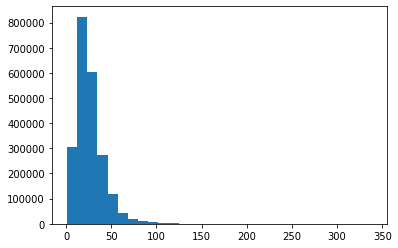

In [84]:
# Check distribution
import matplotlib.pyplot as plt
plt.hist(sent_all_lens, bins=30);

In [85]:
# Check for 95th percentile
output_all_seq_len = int(np.percentile(sent_all_lens, 95))
output_all_seq_len

54

### Creating token-level vectorizer

In [86]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 331000 # based on table 2 in https://arxiv.org/pdf/1710.06071
token_vectorizer_all_data = TextVectorization(max_tokens=max_tokens,
                                             output_sequence_length=output_all_seq_len,
                                             name="token_vectorizer_all_data")

In [87]:
# Adapt text vectorizer to 25% of training data
import random
train_all_sentences_25_percent = random.choices(train_all_sentences, k=int(0.25*len(train_all_sentences)))
token_vectorizer_all_data.adapt(train_all_sentences_25_percent)

In [88]:
# Find number of words in training vocabulary
rct_200k_text_vocab = token_vectorizer_all_data.get_vocabulary()
len(rct_200k_text_vocab)

127760

### Creating custom token-level embedding

In [89]:
token_embedding_all_data = layers.Embedding(input_dim=len(rct_200k_text_vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name="token_embedding_all_data",
                                            input_length=output_all_seq_len)

### Creating character-level vectorizer

In [71]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [72]:
# Split sequence level data splits into character level data splits
train_all_chars = [split_chars(sentence) for sentence in train_all_sentences]
val_all_chars = [split_chars(sentence) for sentence in val_all_sentences]
test_all_chars = [split_chars(sentence) for sentence in test_all_sentences]

In [92]:
# Find average character length
char_all_len = [len(sentence) for sentence in train_all_sentences]
mean_char_all_len = np.mean(char_all_len)
mean_char_all_len

147.82646377869133

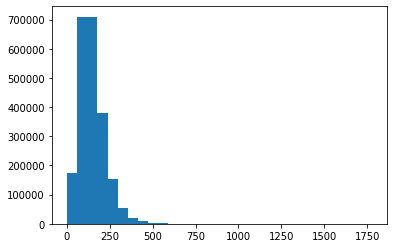

In [93]:
# Check distribution of sequences at a character level
plt.hist(char_all_len, bins=30);

In [94]:
# Check for 95th percentile
output_all_seq_char_len = int(np.percentile(char_all_len, 95))
output_all_seq_char_len

284

In [95]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [96]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer_all_data = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                             output_sequence_length=output_all_seq_char_len,
                                             name="char_vectorizer_all_data")

In [97]:
# Adapt character vectorizer to 25% of training data
import random
train_all_chars_25_percent = random.choices(train_all_chars, k=int(0.25*len(train_all_chars)))
char_vectorizer_all_data.adapt(train_all_chars_25_percent)

In [98]:
# Check character vocabulary
char_all_vocab = char_vectorizer_all_data.get_vocabulary()
len(char_all_vocab)

28

### Creating character-level embedding

In [99]:
char_embedding_all_data = layers.Embedding(input_dim=len(char_all_vocab),
                                           output_dim=25,
                                           mask_zero=True,
                                           name="char_embedding_all_data")

### Creating positional embeddings

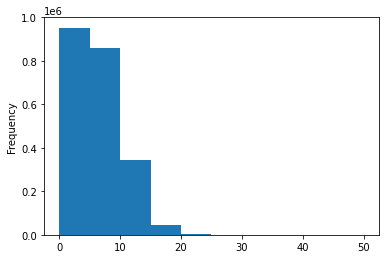

In [100]:
# Check the distribution of line_number column
train_all_df.line_number.plot.hist();

In [73]:
# Use TensorFlow to create one-hot encoded tensors of the line_number feature
train_all_line_number_one_hot = tf.one_hot(train_all_df["line_number"].to_numpy(), depth=15)
val_all_line_number_one_hot = tf.one_hot(val_all_df["line_number"].to_numpy(), depth=15)
test_all_line_number_one_hot = tf.one_hot(test_all_df["line_number"].to_numpy(), depth=15)

train_all_line_number_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

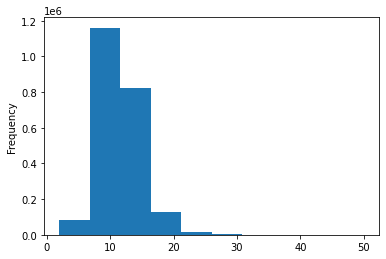

In [102]:
# Check the distribution of total lines column
train_all_df.total_lines.plot.hist();

In [74]:
# Use TensorFlow to create one-hot encoded tensors of the total_lines feature
train_all_total_lines_one_hot = tf.one_hot(train_all_df["total_lines"].to_numpy(), depth=20)
val_all_total_lines_one_hot = tf.one_hot(val_all_df["total_lines"].to_numpy(), depth=20)
test_all_total_lines_one_hot = tf.one_hot(test_all_df["total_lines"].to_numpy(), depth=20)

train_all_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
     

### Creating tribrid embedding datasets using tf.data

In [75]:
# Create training, validation and test datasets with all 4 kinds of input data
train_tribrid_all_data = tf.data.Dataset.from_tensor_slices((train_all_line_number_one_hot,
                                                             train_all_total_lines_one_hot,
                                                             train_all_sentences,
                                                             train_all_chars))
train_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(train_all_labels_one_hot)
train_tribrid_all_dataset = tf.data.Dataset.zip((train_tribrid_all_data, train_tribrid_all_labels))
train_tribrid_all_dataset = train_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_all_data = tf.data.Dataset.from_tensor_slices((val_all_line_number_one_hot,
                                                             val_all_total_lines_one_hot,
                                                             val_all_sentences,
                                                             val_all_chars))
val_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(val_all_labels_one_hot)
val_tribrid_all_dataset = tf.data.Dataset.zip((val_tribrid_all_data, val_tribrid_all_labels))
val_tribrid_all_dataset = val_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_all_data = tf.data.Dataset.from_tensor_slices((test_all_line_number_one_hot,
                                                             test_all_total_lines_one_hot,
                                                             test_all_sentences,
                                                             test_all_chars))
test_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(test_all_labels_one_hot)
test_tribrid_all_dataset = tf.data.Dataset.zip((test_tribrid_all_data, test_tribrid_all_labels))
test_tribrid_all_dataset = test_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Building a custom tribrid embedding model

In [ ]:
# Token inputs model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_inputs")
token_vectorizer = token_vectorizer_all_data(token_inputs)
token_embeddings = token_embedding_all_data(token_vectorizer)
token_flatten = layers.Flatten()(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(token_flatten)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = char_vectorizer_all_data(char_inputs)
char_embeddings = char_embedding_all_data(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
# Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [ ]:
# Combine the models
custom_hybrid_embeddings = layers.Concatenate(name="custom_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(custom_hybrid_embeddings)
z = layers.Dropout(0.5)(z)

custom_tribrid_embeddings = layers.Concatenate(name="custom_tribrid_embedding")([line_number_model.output, total_lines_model.output, z])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(custom_tribrid_embeddings)

model_7 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_7_custom_tribrid_embedding_model_all_data")

In [ ]:
# Get a summary of the model
model_7.summary()

Model: "model_7_custom_tribrid_embedding_model_all_data"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 token_vectorizer_all_data (Tex  (None, 54)          0           ['token_inputs[0][0]']           
 tVectorization)                                                                                  
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_embedding_all_data (Embe  (None, 54, 128)    

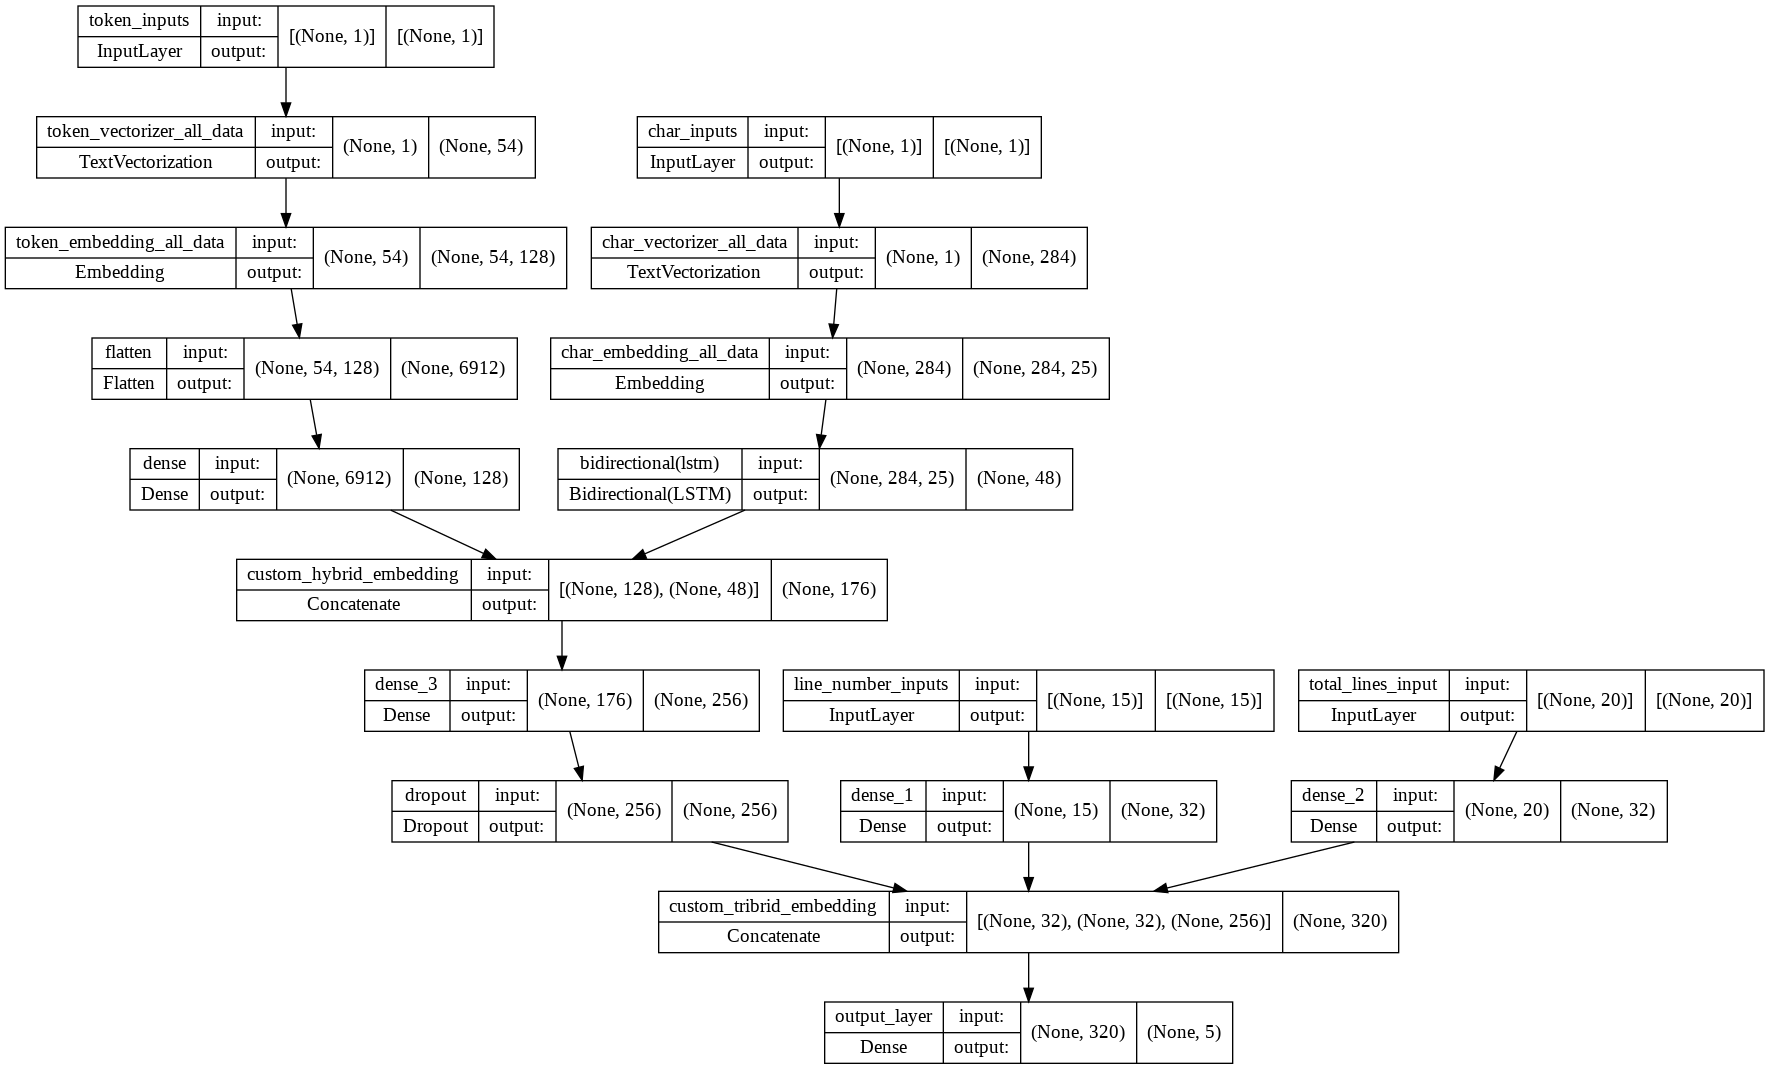

In [ ]:
# Plot model_7
tf.keras.utils.plot_model(model_7, show_shapes=True)

In [ ]:
# Compile the model
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating ModelCheckpoint and EarlyStopping callbacks

In [ ]:
# Set checkpoint path
checkpoint_path = "custom_tribrid_embeddings_all_data_model_checkpoint_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
# Set up EarlyStopping callback to stop training if model's val loss doesn't improve for 3 epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

### Fitting the model on all the training data

In [ ]:
# Fit the model
model_7_history = model_7.fit(train_tribrid_all_dataset,
                              epochs=100,
                              steps_per_epoch=int(0.1*len(train_tribrid_all_dataset)),
                              validation_data=val_tribrid_all_dataset,
                              validation_steps=int(0.1*len(val_tribrid_all_dataset)),
                              callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/100
6912/6912 [==============================] - ETA: 0s - loss: 0.9171 - accuracy: 0.8449
Epoch 1: val_loss improved from inf to 0.88370, saving model to custom_tribrid_embeddings_all_data_model_checkpoint_weights/checkpoint.ckpt
6912/6912 [==============================] - 885s 126ms/step - loss: 0.9171 - accuracy: 0.8449 - val_loss: 0.8837 - val_accuracy: 0.8705
Epoch 2/100
6912/6912 [==============================] - ETA: 0s - loss: 0.8836 - accuracy: 0.8683
Epoch 2: val_loss improved from 0.88370 to 0.88099, saving model to custom_tribrid_embeddings_all_data_model_checkpoint_weights/checkpoint.ckpt
6912/6912 [==============================] - 859s 124ms/step - loss: 0.8836 - accuracy: 0.8683 - val_loss: 0.8810 - val_accuracy: 0.8747
Epoch 3/100
6912/6912 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.8704
Epoch 3: val_loss improved from 0.88099 to 0.87187, saving model to custom_tribrid_embeddings_all_data_model_checkpoint_weights/checkpoint.ckpt
6

In [ ]:
# Evaluate the model
model_7.evaluate(val_tribrid_all_dataset)

905/905 [==============================] - 36s 40ms/step - loss: 0.8519 - accuracy: 0.8836


[0.8518685102462769, 0.8835545182228088]

In [ ]:
# Make predictions
model_7_pred_probs = model_7.predict(val_tribrid_all_dataset)
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)

In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate results
model_7_results = calculate_results(val_all_labels_encoded, model_7_preds)
model_7_results

{'accuracy': 88.35545416839486,
 'f1': 0.8825671522135754,
 'precision': 0.8841272341108678,
 'recall': 0.8835545416839485}

In [ ]:
# Save the model
model_7.save("/content/drive/MyDrive/tensorflow/skimlit/model_7")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_7/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_7/assets


### Making predictions on test data

In [ ]:
# Evaluate on test dataset
model_7.evaluate(test_tribrid_all_dataset)

922/922 [==============================] - 38s 41ms/step - loss: 0.8540 - accuracy: 0.8827


[0.8540216088294983, 0.8826501369476318]

In [ ]:
# Make predictions
model_7_test_pred_probs = model_7.predict(test_tribrid_all_dataset)
model_7_test_preds = tf.argmax(model_7_test_pred_probs, axis=1)

In [ ]:
# Calculate results
model_7_test_results = calculate_results(test_all_labels_encoded, model_7_test_preds)
model_7_test_results

{'accuracy': 88.26501203675448,
 'f1': 0.8813675417388485,
 'precision': 0.8822777374367071,
 'recall': 0.8826501203675449}

In [ ]:
predictions_all_data = pd.DataFrame({"line_number": test_all_df["line_number"],
                                     "total_lines": test_all_df["total_lines"],
                                     "text": test_all_sentences,
                                     "target": test_all_df["target"],
                                     "pred": [class_names[i] for i in model_7_test_preds],
                                     "pred_probs": model_7_test_pred_probs.max(axis=1)})
predictions_all_data.head(20)

,line_number,total_lines,text,target,pred,pred_probs
0,0,10,many pathogenic processes and diseases are the...,BACKGROUND,BACKGROUND,0.741913
1,1,10,it was recently demonstrated that supraphysiol...,BACKGROUND,BACKGROUND,0.561657
2,2,10,"in the present study , we examined the associa...",BACKGROUND,BACKGROUND,0.470090
3,3,10,"in addition , we compared plasma levels of map...",BACKGROUND,METHODS,0.500923
4,4,10,a total of @ mi patients and @ control persons...,METHODS,RESULTS,0.559686
5,5,10,plasma samples were obtained and analysed with...,METHODS,METHODS,0.795357
6,6,10,the myocardial outcomes ( salvage index and fi...,METHODS,METHODS,0.557513
7,7,10,mi patients had @ % higher plasma levels of ma...,RESULTS,RESULTS,0.875291
8,8,10,"however , neither salvage index ( spearman rho...",RESULTS,RESULTS,0.861058
9,9,10,"likewise , masp-@ and masp-@ were elevated in ...",RESULTS,RESULTS,0.816047


> Training on 100% of the data (200K RCT) improved the model's performance.

## Using pretrained GloVe embeddings on the RCT 20K dataset

Check out the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) and implement it in one of the models by incorporating it with a custom token Embedding layer.

### Getting and preprocessing the data

In [1]:
from helper_functions import get_lines
from helper_functions import preprocess_text_with_line_numbers

In [2]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")

In [4]:
# Visualise samples as DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)

In [5]:
# Convert abstract text lines to lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()

### Make numeric labels (ML models require numeric labels)

In [6]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # sparse matrix is incomptible with tensors
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

#### Label encode labels

In [7]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

In [8]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Creating text vectorizer layer

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

text_vectorizer_glove = TextVectorization(max_tokens=68000,
                                          output_sequence_length=55,
                                          name="vectorizer_glove")

In [10]:
# Adapt text vectorizer to training sentences
text_vectorizer_glove.adapt(train_sentences)

In [11]:
# Get vocabulary
text_vocab_glove = text_vectorizer_glove.get_vocabulary()
len(text_vocab_glove)

64841

In [12]:
# Dictionary mapping words to their indices
glove_word_index = dict(zip(text_vocab_glove, range(len(text_vocab_glove))))

### Creating datasets

In [13]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

### Load pre-trained GloVe embeddings

In [14]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-05-17 09:55:39--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-17 09:55:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.13MB/s    in 2m 39s  

2022-05-17 09:58:19 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [15]:
# Make a dictionary mapping words to their NumPy vector representation
import os
import numpy as np
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [16]:
# Prepare an embedding matrix to use in a Keras embedding layer
num_tokens = len(text_vocab_glove) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in glove_word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1

print(f"Converted {hits} words ({misses} misses).")

Converted 29730 words (35111 misses).


In [17]:
# Load pre-trained word embeddings matrix into an embedding layer
from tensorflow.keras.layers import Embedding

embedding_glove = Embedding(input_dim=num_tokens,
                            output_dim=embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=True,
                            name="embedding_glove")

### Build the model

In [18]:
# Replicate model_1
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectorizer = text_vectorizer_glove(inputs)
embedding_layer = embedding_glove(text_vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(embedding_layer)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_8 = tf.keras.Model(inputs, outputs, name="model_8_pretrained_glove_embeddings")

In [19]:
# Compile the model
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [20]:
# Fit the model
model_8_history = model_8.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 8ms/step - loss: 0.9199 - accuracy: 0.6421 - val_loss: 0.7562 - val_accuracy: 0.7207
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7004 - accuracy: 0.7438 - val_loss: 0.6915 - val_accuracy: 0.7487
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6460 - accuracy: 0.7648 - val_loss: 0.6205 - val_accuracy: 0.7743


In [21]:
# Evaluate the model
model_8.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6228 - accuracy: 0.7764


[0.6228063106536865, 0.7764464616775513]

In [22]:
from helper_functions import calculate_results

In [ ]:
# Make predictions and calculate results
model_8_pred_probs = model_8.predict(val_dataset)
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_results = calculate_results(val_labels_encoded, model_8_preds)
model_8_results

{'accuracy': 77.73732291804582,
 'f1': 0.7759979843976185,
 'precision': 0.7763544142361081,
 'recall': 0.7773732291804581}

In [ ]:
# Save the model
model_8.save("/content/drive/MyDrive/tensorflow/skimlit/model_8")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_8/assets


> `model_8` (GloVe embeddings) performed a litle worse than `model_1` (custom token embeddings)

## Using TensorFlow Hub BERT PubMed expert

Replace the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding.

In [23]:
pip install tensorflow-text

In [24]:
import tensorflow
import tensorflow_hub as hub
import tensorflow_text as tf_text

In [25]:
#@title Select BERT PubMed Expert model
bert_model_name = 'experts_pubmed' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/experts/bert/pubmed/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [26]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess, name="BERT_preprocessing_layer")
bert_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name="BERT_encoder_layer")

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
# Replicate model_2
inputs = layers.Input(shape=(), dtype=tf.string, name="input_layer")
encoder_inputs = bert_preprocess(inputs)
x = bert_encoder(encoder_inputs)
x = x["sequence_output"]
x = layers.Dense(128, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_9 = tf.keras.Model(inputs, outputs, name="model_9_tfhub_BERT_PubMed_expert")

In [29]:
# Compile the model
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
# Get a summary
model_9.summary()

Model: "model_9_tfhub_BERT_PubMed_expert"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessing_layer (Kera  {'input_mask': (Non  0          ['input_layer[0][0]']            
 sLayer)                        e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                       

In [31]:
# Fit the model
model_9_history = model_9.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 229s 385ms/step - loss: 0.5076 - accuracy: 0.8198 - val_loss: 0.4142 - val_accuracy: 0.8547
Epoch 2/3
562/562 [==============================] - 216s 384ms/step - loss: 0.4191 - accuracy: 0.8499 - val_loss: 0.4056 - val_accuracy: 0.8580
Epoch 3/3
562/562 [==============================] - 216s 384ms/step - loss: 0.4047 - accuracy: 0.8540 - val_loss: 0.3953 - val_accuracy: 0.8604


In [ ]:
# Evaluate results
model_9.evaluate(val_dataset)

945/945 [==============================] - 625s 661ms/step - loss: 0.3898 - accuracy: 0.8585


[0.3898047208786011, 0.8585330247879028]

In [ ]:
# Make predictions and calculate results
model_9_pred_probs = model_9.predict(val_dataset)
model_9_preds = tf.argmax(model_9_pred_probs, axis=1)
model_9_results = calculate_results(val_labels_encoded, model_9_preds)
model_9_results

{'accuracy': 85.85330332318284,
 'f1': 0.85817503753837,
 'precision': 0.8585070178777338,
 'recall': 0.8585330332318284}

In [ ]:
# Save the model
model_9.save("/content/drive/MyDrive/tensorflow/skimlit/model_9")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_9/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_9/assets


> `model_9` (BERT PubMed expert pre-trained embeddings) performed better than `model_2` (USE pre-trained embeddings)

## Merge `line_number` and `total_lines` features for each sequence

In [38]:
# Combining the total lines and line number into a new feature
train_df["line_number_total"] = train_df["line_number"].astype(str) + "_of_" + train_df["total_lines"].astype(str)
val_df["line_number_total"] = val_df["line_number"].astype(str) + "_of_" + val_df["total_lines"].astype(str)

train_df.head(10)

,line_number,target,text,total_lines,line_number_total
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11,0_of_11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11,1_of_11
2,2,METHODS,outcome measures included pain reduction and i...,11,2_of_11
3,3,METHODS,pain was assessed using the visual analog pain...,11,3_of_11
4,4,METHODS,secondary outcome measures included the wester...,11,4_of_11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11,5_of_11
6,6,RESULTS,there was a clinically relevant reduction in t...,11,6_of_11
7,7,RESULTS,the mean difference between treatment arms ( @...,11,7_of_11
8,8,RESULTS,"further , there was a clinically relevant redu...",11,8_of_11
9,9,RESULTS,these differences remained significant at @ we...,11,9_of_11


In [39]:
# Perform one hot encoding on the training data and transform the training and validation DataFrames
from sklearn.preprocessing import OneHotEncoder
import numpy as np

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(np.expand_dims(train_df["line_number_total"], axis=1))

train_line_number_total_one_hot = one_hot_encoder.transform(np.expand_dims(train_df["line_number_total"], axis=1))
val_line_number_total_one_hot = one_hot_encoder.transform(np.expand_dims(val_df["line_number_total"], axis=1))

train_line_number_total_one_hot[:10]

<10x460 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [40]:
# Convert the sparse object to array
train_line_number_total_one_hot = train_line_number_total_one_hot.toarray()
val_line_number_total_one_hot = val_line_number_total_one_hot.toarray()

# Convert the datatype to int
train_line_number_total_one_hot = tf.cast(train_line_number_total_one_hot, dtype=tf.int32)
val_line_number_total_one_hot = tf.cast(val_line_number_total_one_hot, dtype=tf.int32)

train_line_number_total_one_hot[:10]

<tf.Tensor: shape=(10, 460), dtype=int32, numpy=
array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [41]:
# Making the datasets for the model
train_combined_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_total_one_hot, train_sentences, train_chars))
train_combined_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_combined_tribrid_dataset = tf.data.Dataset.zip((train_combined_tribrid_data, train_combined_tribrid_labels))
train_combined_tribrid_dataset = train_combined_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_combined_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_total_one_hot, val_sentences, val_chars))
val_combined_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_combined_tribrid_dataset = tf.data.Dataset.zip((val_combined_tribrid_data, val_combined_tribrid_labels))
val_combined_tribrid_dataset = val_combined_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_combined_tribrid_dataset, val_combined_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 460), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 460), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [42]:
# Creating token-level vectorizer and embedding layer
from tensorflow.keras.layers import TextVectorization

model_10_token_vectorizer = TextVectorization(max_tokens=68000,
                                        output_sequence_length=55,
                                        name="token_vectorizer_10")
model_10_token_vectorizer.adapt(train_sentences)
rct_20k_text_vocab = model_10_token_vectorizer.get_vocabulary()

model_10_token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                      output_dim=128,
                                      mask_zero=True,
                                      input_length=55,
                                      name="token_embedding_10")

In [43]:
# Creating character-level vectorizer and embedding layer
model_10_char_vectorizer = TextVectorization(max_tokens=70,
                                             output_sequence_length=290,
                                             name="char_vectorizer_10")
model_10_char_vectorizer.adapt(train_chars)
char_vocab = model_10_char_vectorizer.get_vocabulary()

model_10_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="char_embedding_10")

In [44]:
# Replicate model_6

# Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_inputs")
token_vectorizer = model_10_token_vectorizer(token_inputs)
token_embeddings = model_10_token_embedding(token_vectorizer)
token_flatten = layers.Flatten()(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(token_flatten)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = model_10_char_vectorizer(char_inputs)
char_embeddings = model_10_char_embedding(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line number total model
line_number_total_inputs = layers.Input(shape=(460,), dtype=tf.int32, name="line_number_total_inputs")
x = layers.Dense(32, activation="relu")(line_number_total_inputs)
line_number_total_model = tf.keras.Model(line_number_total_inputs, x)

# Combine the models
custom_hybrid_embeddings = layers.Concatenate(name="custom_hybrid_embedding")([token_model.output, char_model.output])
y = layers.Dense(256, activation="relu")(custom_hybrid_embeddings)
y = layers.Dropout(0.5)(y)

custom_tribrid_embeddings = layers.Concatenate(name="custom_tribrid_embedding")([line_number_total_model.output, y])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(custom_tribrid_embeddings)
model_10 = tf.keras.Model(inputs=[line_number_total_model.input, token_model.input, char_model.input],
                          outputs=output_layer,
                          name="model_10_custom_tribrid_line_number_total_model")

In [ ]:
model_10.summary()

Model: "model_10_custom_tribrid_line_number_total_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 token_vectorizer_10 (TextVecto  (None, 55)          0           ['token_inputs[0][0]']           
 rization)                                                                                        
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_embedding_10 (Embedding)  (None, 55, 128)    

In [45]:
# Compile the model
model_10.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [46]:
# Fit the model
model_10_history = model_10.fit(train_combined_tribrid_dataset,
                                epochs=3,
                                steps_per_epoch=int(0.1*len(train_combined_tribrid_dataset)),
                                validation_data=val_combined_tribrid_dataset,
                                validation_steps=int(0.1*len(val_combined_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 57ms/step - loss: 1.1054 - accuracy: 0.7106 - val_loss: 0.9196 - val_accuracy: 0.8461
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9086 - accuracy: 0.8540 - val_loss: 0.8897 - val_accuracy: 0.8710
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.8908 - accuracy: 0.8640 - val_loss: 0.8848 - val_accuracy: 0.8723


In [ ]:
# Evaluate the model
model_10.evaluate(val_combined_tribrid_dataset)

945/945 [==============================] - 39s 41ms/step - loss: 0.8794 - accuracy: 0.8712


[0.8794460296630859, 0.8711770176887512]

In [ ]:
# Make predictions and calculate result
model_10_pred_probs = model_10.predict(val_combined_tribrid_dataset)
model_10_preds = tf.argmax(model_10_pred_probs, axis=1)
model_10_results = calculate_results(val_labels_encoded, model_10_preds)
model_10_results

{'accuracy': 87.1177015755329,
 'f1': 0.8698632121326043,
 'precision': 0.8695406637587768,
 'recall': 0.871177015755329}

In [ ]:
# Save the model
model_10.save("/content/drive/MyDrive/tensorflow/skimlit/model_10")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit/model_10/assets


> `model_10` performed better than `model_6`, merging the `line_number` and `total_lines` features improved the performance of the model

## Combine all model results

In [48]:
from helper_functions import calculate_results

In [49]:
# Create function to make predictions and calculate results
def evaluate_predictions(model, val_data, y_true):
  model_pred_probs = model.predict(val_data)
  model_preds = tf.argmax(model_pred_probs, axis=1)
  model_results = calculate_results(y_true, model_preds)
  return model_results

In [76]:
model_7 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/skimlit/model_7")

In [80]:
# Get the results of each model
baseline_results = calculate_results(val_labels_encoded, model_0.predict(val_sentences))
model_1_results = evaluate_predictions(model_1, val_dataset, val_labels_encoded)
model_2_results = evaluate_predictions(model_2, val_dataset, val_labels_encoded)
model_3_results = evaluate_predictions(model_3, val_char_dataset, val_labels_encoded)
model_4_results = evaluate_predictions(model_4, val_token_char_dataset, val_labels_encoded)
model_5_results = evaluate_predictions(model_5, val_tribrid_dataset, val_labels_encoded)
model_6_results = evaluate_predictions(model_6, val_tribrid_dataset, val_labels_encoded)
model_7_results = evaluate_predictions(model_7, val_tribrid_all_dataset, val_all_labels_encoded)

In [83]:
model_0_to_7_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                     "model_1_custom_token_embedding": model_1_results,
                                     "model_2_USE_pretrained_token_embedding": model_2_results,
                                     "model_3_char_embedding": model_3_results,
                                     "model_4_hybrid_token_char_embedding": model_4_results,
                                     "model_5_tribrid_pos_token_char_embedding": model_5_results,
                                     "model_6_custom_tribrid_pos_token_char_embedding": model_6_results,
                                     "model_7_all_data_custom_tribrid_pos_token_char_embedding": model_7_results})
model_0_to_7_results.transpose()

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.611148,0.782772,0.786111,0.783541
model_2_USE_pretrained_token_embedding,71.458361,0.714521,0.714584,0.711782
model_3_char_embedding,65.765259,0.656802,0.657653,0.647301
model_4_hybrid_token_char_embedding,73.232490,0.730681,0.732325,0.729255
model_5_tribrid_pos_token_char_embedding,83.380776,0.832665,0.833808,0.832747
model_6_custom_tribrid_pos_token_char_embedding,85.022508,0.848831,0.850225,0.849423
model_7_all_data_custom_tribrid_pos_token_char_embedding,88.355454,0.884127,0.883555,0.882567


In [84]:
from google.colab import files

model_0_to_7_results.to_csv('model_0_to_7_results.csv')
files.download('model_0_to_7_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
model_8_results = evaluate_predictions(model_8, val_dataset, val_labels_encoded)
model_9_results = evaluate_predictions(model_9, val_dataset, val_labels_encoded)
model_10_results = evaluate_predictions(model_10, val_combined_tribrid_dataset, val_labels_encoded)

In [52]:
# Combine results into a dataframe
model_8_to_10_results = pd.DataFrame({"model_8_GloVe_pretrained_token_embedding": model_8_results,
                                      "model_9_BERT_PubMed_Expert_pretrained_token_embedding": model_9_results,
                                      "model_10_custom_tribrid_post_token_char_embedding_with_combined_line_number_total": model_10_results})

model_8_to_10_results.transpose()

,accuracy,precision,recall,f1
model_8_GloVe_pretrained_token_embedding,77.644645,0.775913,0.776446,0.775047
model_9_BERT_PubMed_Expert_pretrained_token_embedding,86.101549,0.860443,0.861015,0.860530
model_10_custom_tribrid_post_token_char_embedding_with_combined_line_number_total,87.326228,0.872903,0.873262,0.872312


In [53]:
from google.colab import files

model_8_to_10_results.to_csv('model_8_to_10_results.csv')
files.download('model_8_to_10_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
import io
model_0_to_7_results = pd.read_csv("/content/model_0_to_7_results.csv")
model_0_to_7_results = model_0_to_7_results.transpose()
model_0_to_7_results, model_0_to_7_results.columns = model_0_to_7_results[1:], model_0_to_7_results.iloc[0]
model_0_to_7_results

Unnamed: 0,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.611148,0.782772,0.786111,0.783541
model_2_USE_pretrained_token_embedding,71.458361,0.714521,0.714584,0.711782
model_3_char_embedding,65.765259,0.656802,0.657653,0.647301
model_4_hybrid_token_char_embedding,73.23249,0.730681,0.732325,0.729255
model_5_tribrid_pos_token_char_embedding,83.380776,0.832665,0.833808,0.832747
model_6_custom_tribrid_pos_token_char_embedding,85.022508,0.848831,0.850225,0.849423
model_7_all_data_custom_tribrid_pos_token_char_embedding,88.355454,0.884127,0.883555,0.882567


In [79]:
model_8_to_10_results = pd.read_csv("/content/model_8_to_10_results.csv")
model_8_to_10_results = model_8_to_10_results.transpose()
model_8_to_10_results, model_8_to_10_results.columns = model_8_to_10_results[1:], model_8_to_10_results.iloc[0]
model_8_to_10_results

Unnamed: 0,accuracy,precision,recall,f1
model_8_GloVe_pretrained_token_embedding,77.644645,0.775913,0.776446,0.775047
model_9_BERT_PubMed_Expert_pretrained_token_embedding,86.101549,0.860443,0.861015,0.86053
model_10_custom_tribrid_post_token_char_embedding_with_combined_line_number_total,87.326228,0.872903,0.873262,0.872312


In [83]:
all_10_model_results = pd.concat([model_0_to_7_results, model_8_to_10_results], axis=0)
all_10_model_results

Unnamed: 0,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.611148,0.782772,0.786111,0.783541
model_2_USE_pretrained_token_embedding,71.458361,0.714521,0.714584,0.711782
model_3_char_embedding,65.765259,0.656802,0.657653,0.647301
model_4_hybrid_token_char_embedding,73.23249,0.730681,0.732325,0.729255
model_5_tribrid_pos_token_char_embedding,83.380776,0.832665,0.833808,0.832747
model_6_custom_tribrid_pos_token_char_embedding,85.022508,0.848831,0.850225,0.849423
model_7_all_data_custom_tribrid_pos_token_char_embedding,88.355454,0.884127,0.883555,0.882567
model_8_GloVe_pretrained_token_embedding,77.644645,0.775913,0.776446,0.775047
model_9_BERT_PubMed_Expert_pretrained_token_embedding,86.101549,0.860443,0.861015,0.86053


In [84]:
# Reduce the accuracy to same scale as other metrics
all_10_model_results["accuracy"] = all_10_model_results["accuracy"] / 100

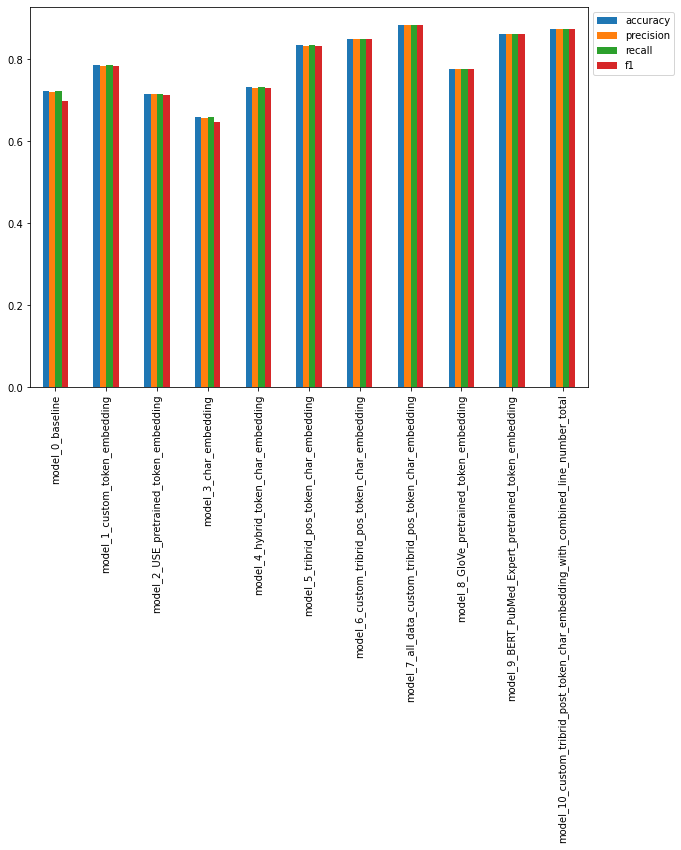

In [85]:
# Plot and compare all model results
all_10_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

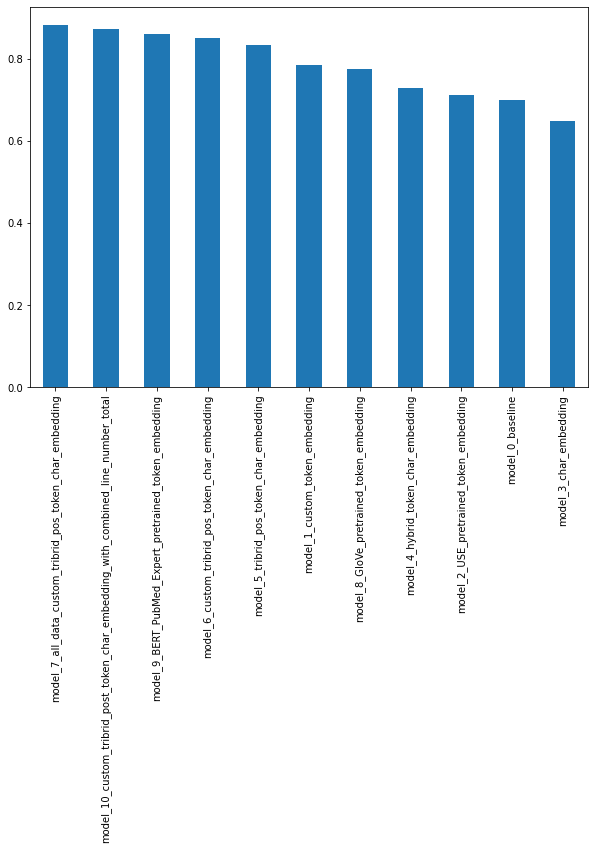

In [87]:
# Sort models results by f1-scores
all_10_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));